In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Library Imports**

In [1]:
import re #libray for regular expression
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
!pip uninstall -y numpy gensim
!pip install numpy gensim

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: gensim 4.3.3
Uninstalling gensim-4.3.3:
  Successfully uninstalled gensim-4.3.3
  Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.7 MB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense, Dropout, Bidirectional, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE


In [4]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

# Loading Data

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Github Projects/3. Spam Detection in Emails/completeSpamAssassin.csv')
df = df.drop(columns=['Unnamed: 0'], errors='ignore')
df = df[df['Body'] != 'empty'].drop_duplicates().reset_index(drop=True)
df.fillna('', inplace=True)

y = df['Label'].values
corpus = df['Body'].astype(str).tolist()

# **Text Vecorization**

In [5]:
tokenized_corpus = [word_tokenize(sentence.lower()) for sentence in corpus]
word2vec_model = Word2Vec(sentences=tokenized_corpus, vector_size=128, window=5, min_count=1, workers=4)

In [6]:
max_words = 5000
max_length = 100

In [7]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(corpus)
X = pad_sequences(tokenizer.texts_to_sequences(corpus), maxlen=max_length)

In [8]:
X_resampled, y_resampled = SMOTE(sampling_strategy='minority', random_state=42).fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=3)

In [9]:
embedding_dim = 128
vocab_size = min(len(tokenizer.word_index) + 1, max_words)
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size and word in word2vec_model.wv.key_to_index:
        embedding_matrix[i] = word2vec_model.wv[word]

In [10]:
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


# **Model Training and Performance Metrics**

In [11]:
def build_and_train_model(model_type="RNN"):
    model = Sequential([embedding_layer])
    if model_type == "RNN":
        model.add(SimpleRNN(128, activation='relu', return_sequences=True))
        model.add(SimpleRNN(64, activation='relu'))
    elif model_type == "LSTM":
        model.add(Bidirectional(LSTM(128, return_sequences=True)))
        model.add(LSTM(64))
    elif model_type == "GRU":
        model.add(Bidirectional(GRU(128, return_sequences=True)))
        model.add(GRU(64))
    elif model_type == "CNN":
        model.add(Conv1D(128, kernel_size=5, activation='relu'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Conv1D(64, kernel_size=5, activation='relu'))
        model.add(MaxPooling1D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    print(f"\nTraining {model_type} Model...")
    model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))
    return model


In [12]:
models = {name: build_and_train_model(name) for name in ["RNN", "LSTM", "GRU", "CNN"]}




Training RNN Model...
Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.7365 - loss: 0.5300 - val_accuracy: 0.8736 - val_loss: 0.3407
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8997 - loss: 0.2774 - val_accuracy: 0.8768 - val_loss: 0.3056
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9355 - loss: 0.2023 - val_accuracy: 0.7822 - val_loss: 0.4635
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9133 - loss: 0.2274 - val_accuracy: 0.9042 - val_loss: 0.2410
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9459 - loss: 0.1488 - val_accuracy: 0.9100 - val_loss: 0.2410
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9500 - loss: 0.1344 - val_accuracy: 0.9068 - val_loss: 0.2395
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9649 - loss: 0.1122 - val_accuracy: 0.9413 - val_loss: 0.1566
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9657 - loss: 0.0998 - v

In [13]:
def evaluate_model(model, X_test, y_test, name):
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    print(f"\n{name} Model Performance:")
    print(classification_report(y_test, y_pred))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step

RNN Model Performance:
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       774
           1       0.98      0.83      0.90       792

    accuracy                           0.90      1566
   macro avg       0.91      0.91      0.90      1566
weighted avg       0.91      0.90      0.90      1566



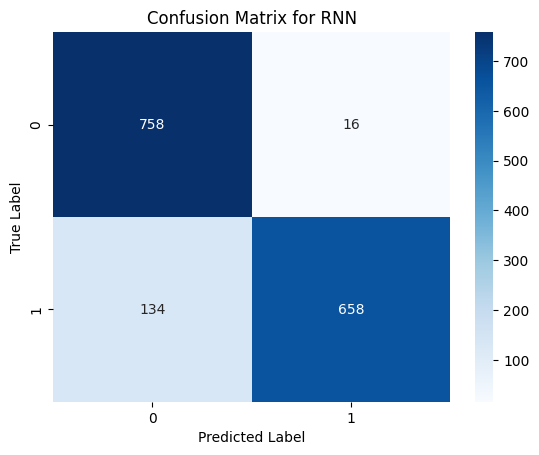

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

LSTM Model Performance:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       774
           1       0.96      0.98      0.97       792

    accuracy                           0.97      1566
   macro avg       0.97      0.97      0.97      1566
weighted avg       0.97      0.97      0.97      1566



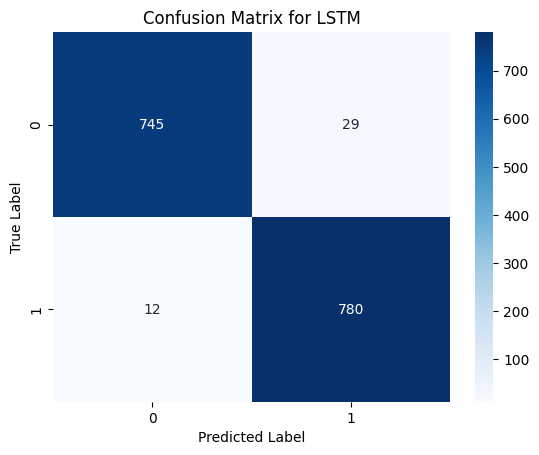

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

GRU Model Performance:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       774
           1       0.97      0.98      0.98       792

    accuracy                           0.98      1566
   macro avg       0.98      0.98      0.98      1566
weighted avg       0.98      0.98      0.98      1566



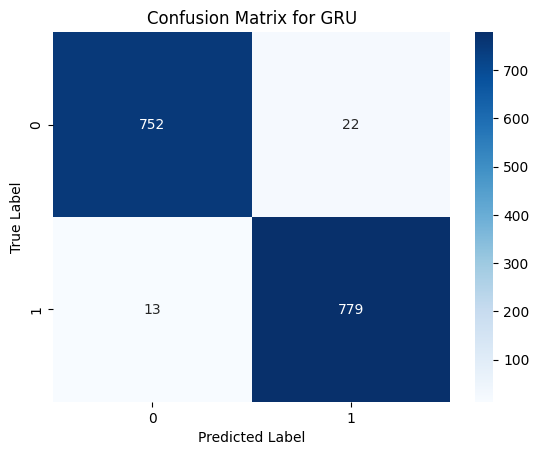

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

CNN Model Performance:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       774
           1       0.96      0.97      0.97       792

    accuracy                           0.97      1566
   macro avg       0.97      0.97      0.97      1566
weighted avg       0.97      0.97      0.97      1566



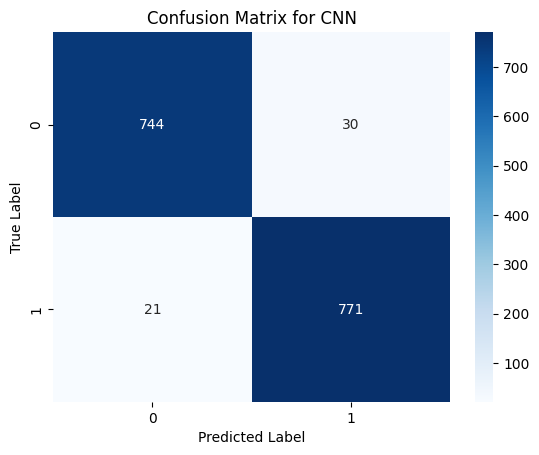

In [14]:
for name, model in models.items():
    evaluate_model(model, X_test, y_test, name)